In [21]:
import pymonntorch

In [22]:
net = pymonntorch.Network()

In [23]:
net.initialize()

Network['Network_1', 'Network'](Neurons: tensor(0.)|0 groups, Synapses: tensor(0.)|0 groups){}


In [24]:
net.simulate_iterations(1000)

1000xBatch: 1/1 (100%) 9.511ms


9.511470794677734

In [25]:
from pymonntorch import *
import torch
from matplotlib import pyplot as plt
import random

# Current

In [26]:
class SetCurrent(Behavior):
	def initialize(self, ng):
		self.offset = self.parameter("value")
		ng.I = ng.vector(mode = self.offset)

	def forward(self, ng):
		ng.I.fill_(self.offset)


class StepFunction(Behavior):
	def initialize(self, ng):
		self.value = self.parameter("value")
		self.t0 = self.parameter("t0")

	def forward(self, ng):
		if ng.network.iteration * ng.network.dt >= self.t0:
			ng.I += ng.vector(mode=self.value) * ng.network.dt


class SinFunc(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = ng.vector(mode = self.value) * np.sin(ng.network.iteration/180 * np.pi)**2 * ng.network.dt


class NoiseFun(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = (ng.vector(mode = self.value) * ng.network.dt + ((random.random() * self.value - self.value/2)))

# class NoiseFun(Behavior):
# 	def initialize(self, ng):
# 		self.value = self.parameter("value", 10)
# 		self.t0 = self.parameter("t0", 50)
		
# 	def forward(self, ng):
# 		if ng.network.iteration * ng.network.dt >= self.t0:
# 			ng.I = (ng.vector(mode = self.value) * ng.network.dt + ((random.random() * self.value - self.value/2)))

# dt

In [27]:
class TimeResolution(Behavior):
	def initialize(self, network):
		network.dt = self.parameter("dt", 1.0)

# Synapse

In [28]:
class SynFun(Behavior):
	def initialize(self, sg):
		sg.W = sg.matrix(mode="normal(0.5, 0.3)")
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class InpSyn(Behavior):
	def forward(self, ng):
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I

on LIF

In [29]:
class LIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset
		ng.A = ng.vector(torch.sum(ng.spike).item() / ng.size)


	def forward(self, ng):
		
		# firing
		ng.spike = ng.v >= self.threshold

		#reset
		ng.v[ng.spike] = self.u_reset
		
		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I
		ng.v += (leakage + currents) / self.tau * ng.network.dt

		ng.A = ng.vector(torch.sum(ng.spike).item() / ng.size)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:NoiseFun(value=60,)5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S100xD100){3:SynFun(),}
100xBatch: 1/1 (100%) 124.727ms


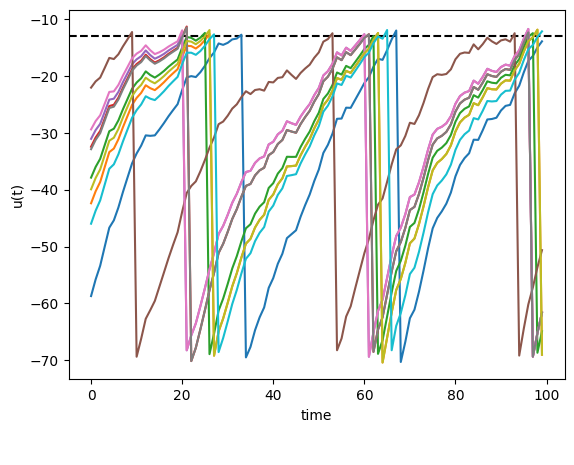

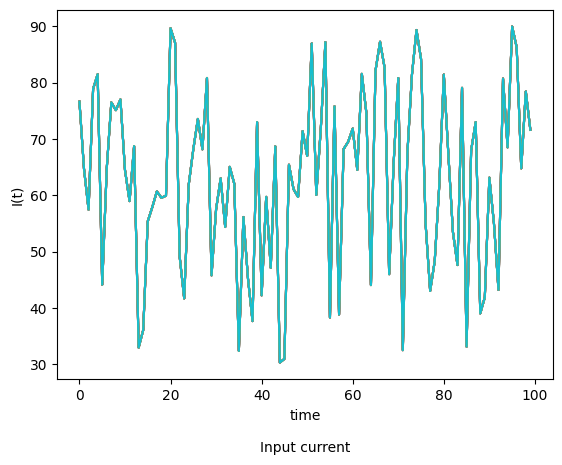

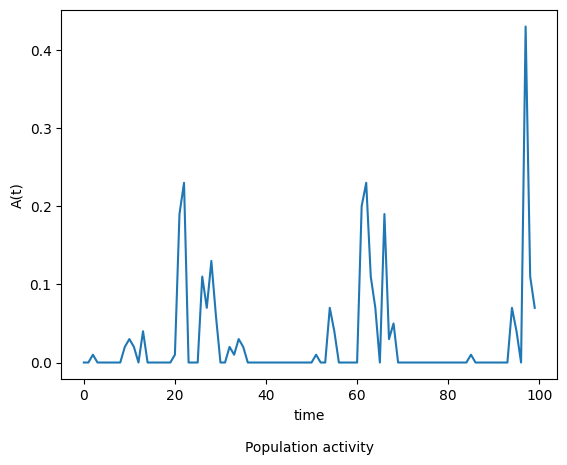

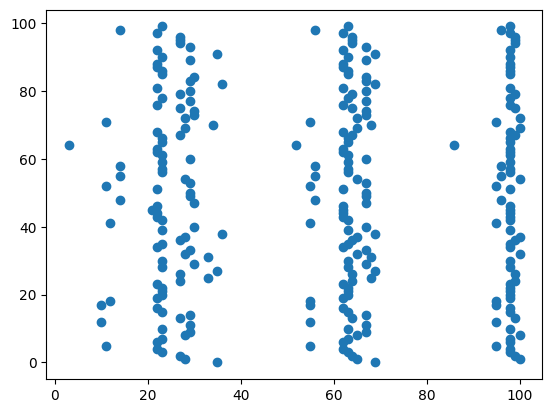

In [30]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    100,
    net=net1,
    behavior={
        2: NoiseFun(value = 60),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                 3: SynFun(),
            })

net1.initialize()

net1.simulate_iterations(100)

# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])


plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net1["v", 0][:,:10])
plt.xlabel("time\n\n")
plt.ylabel("u(t)")
plt.show()

plt.plot(net1["I", 0][:,:10])
plt.xlabel("time\n\nInput current")
plt.ylabel("I(t)")
plt.show()

plt.plot(net1["A", 0][:,:1])
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
plt.show()

# Full connectivity scheme

In [31]:
class SynFun(Behavior):
	def initialize(self, sg):
		# sg.W = sg.matrix(mode="normal(0.5, 0.3)")
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class InpSyn(Behavior):
	def forward(self, ng):
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I

In [32]:
class Full(Behavior):
	def initialize(self, sg):
		self.J_0 = self.parameter("J_0", 1000)
		self.N = sg.dst.size
		sg.W = sg.matrix(self.J_0/self.N)
		

on LIF

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:NoiseFun(value=60,)4:InpSyn()5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S100xD100){3:Full(),4:SynFun(),}
100xBatch: 1/1 (100%) 74.201ms


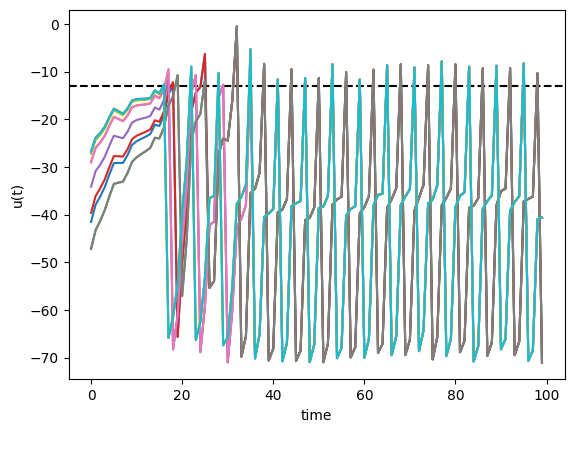

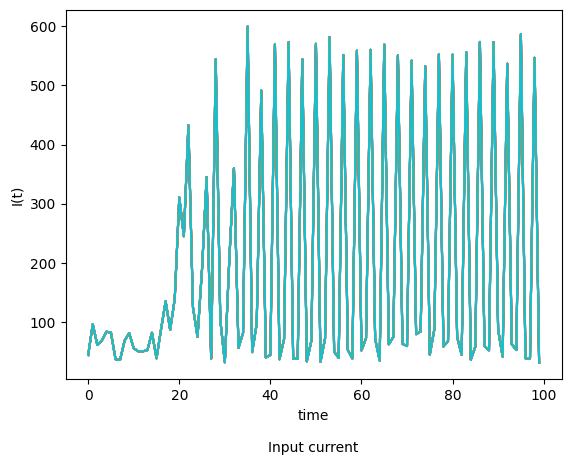

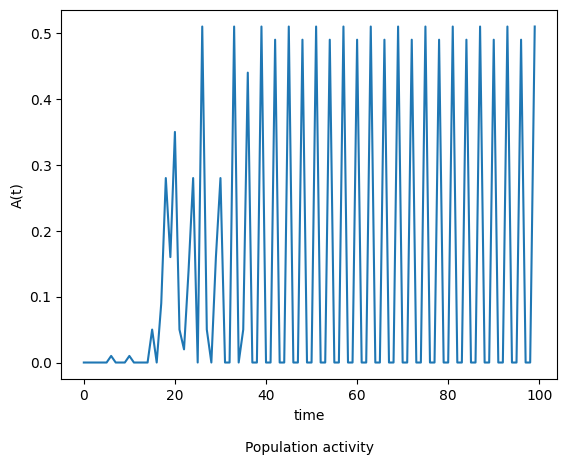

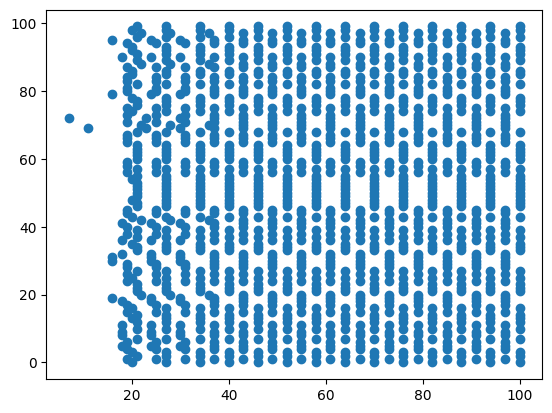

In [33]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    100,
    net=net1,
    behavior={
        2: NoiseFun(value = 60),
        4: InpSyn(),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),

    },
    tag="NG1",
)


SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                 3: Full(),
                 4: SynFun(),
            })

net1.initialize()

net1.simulate_iterations(100)

# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])


plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net1["v", 0][:,:10])
plt.xlabel("time\n\n")
plt.ylabel("u(t)")
plt.show()

plt.plot(net1["I", 0][:,:10])
plt.xlabel("time\n\nInput current")
plt.ylabel("I(t)")
plt.show()

plt.plot(net1["A", 0][:,:1])
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
plt.show()

# Random connectivity with fixed coupling probability

In [34]:
class SynFun(Behavior):
	def initialize(self, sg):
		#sg.W = sg.matrix(mode = 0.5)
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class InpSyn(Behavior):
	def forward(self, ng):
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I

In [35]:
class Fixed_coupling_probability(Behavior):
	def initialize(self, sg):
		self.J_0 = self.parameter("J_0", 500)
		self.N = sg.dst.size
		self.p = 0.8
		sg.W = sg.matrix(self.J_0 / (self.N * self.p))
		helper = torch.rand(sg.matrix_dim())
		for i in range(sg.src.size):
			for j in range(self.N):
				if helper[i][j] < self.p:
					helper[i][j] = 1
				else:
					helper[i][j] = 0
		sg.W *= helper


on LIF

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=50,)3:StepFunction(value=40,t0=20,)4:InpSyn()5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S100xD100){3:Fixed_coupling_probability(),4:SynFun(),}
100xBatch: 1/1 (100%) 63.800ms


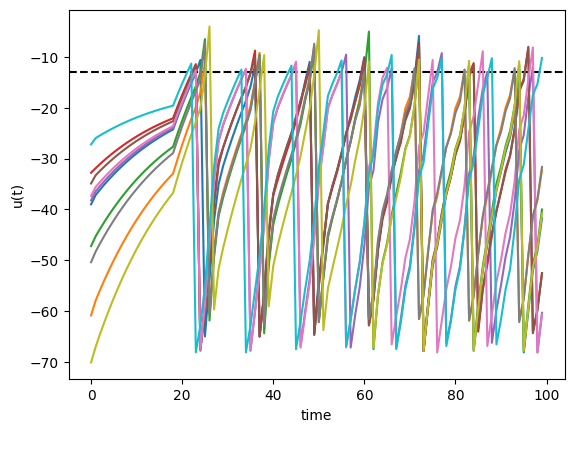

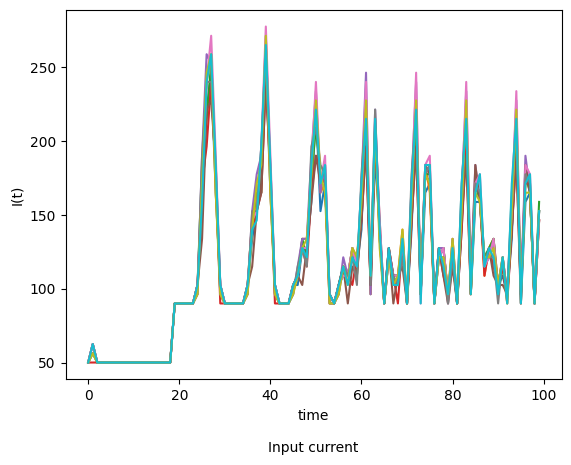

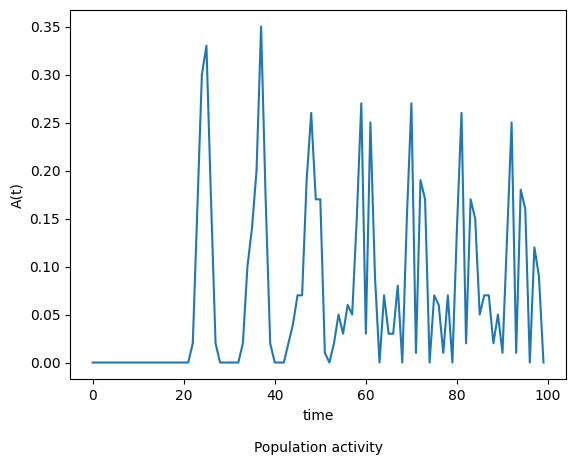

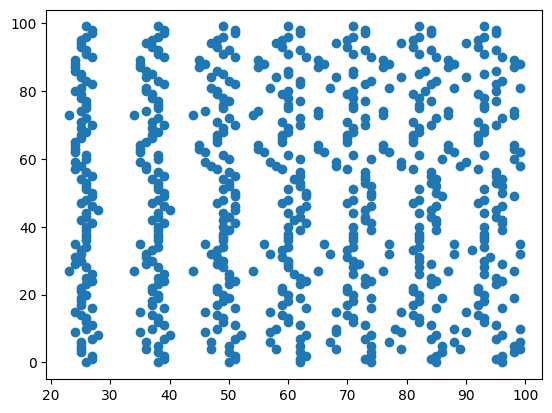

In [36]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    100,
    net=net1,
    behavior={
        2: SetCurrent(value=50),
        3: StepFunction(value=40, t0=20),
        4: InpSyn(),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),

    },
    tag="NG1",
)


SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                3: Fixed_coupling_probability(),
                4: SynFun(),
                 
            })

net1.initialize()

net1.simulate_iterations(100)

# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])


plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net1["v", 0][:,:10])
plt.xlabel("time\n\n")
plt.ylabel("u(t)")
plt.show()

plt.plot(net1["I", 0][:,:10])
plt.xlabel("time\n\nInput current")
plt.ylabel("I(t)")
plt.show()

plt.plot(net1["A", 0][:,:1])
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
plt.show()

# Random connectivity with fixed number of presynaptic partners

In [37]:
class SynFun(Behavior):
	def initialize(self, sg):
		#sg.W = sg.matrix(mode = 0.5)
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class InpSyn(Behavior):
	def forward(self, ng):
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I

In [38]:
class Fixed_partners(Behavior):
	def initialize(self, sg):
		sg.W = sg.get_random_synapse_mat_fixed(min_number_of_synapses=60)

on LIF

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=30,)3:StepFunction(value=50,t0=20,)4:InpSyn()5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-60, 40),)9:Recorder(variables=['v', 'I', 'A'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S100xD100){3:Fixed_partners(),4:SynFun(),}
100xBatch: 1/1 (100%) 39.314ms


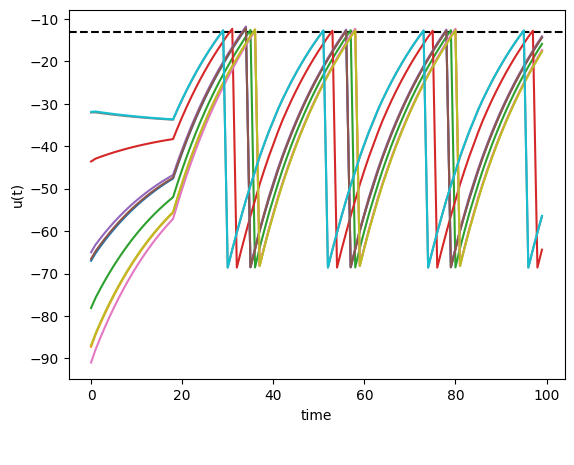

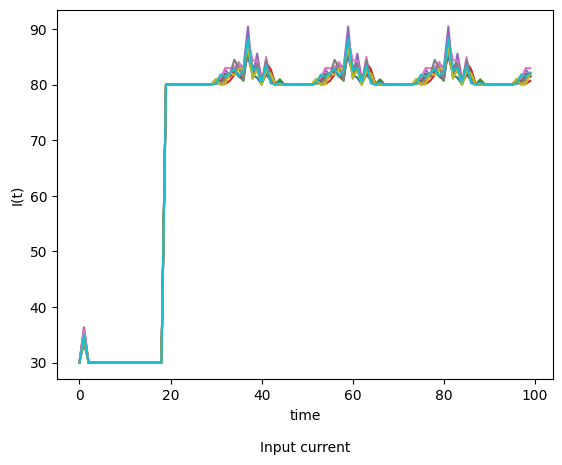

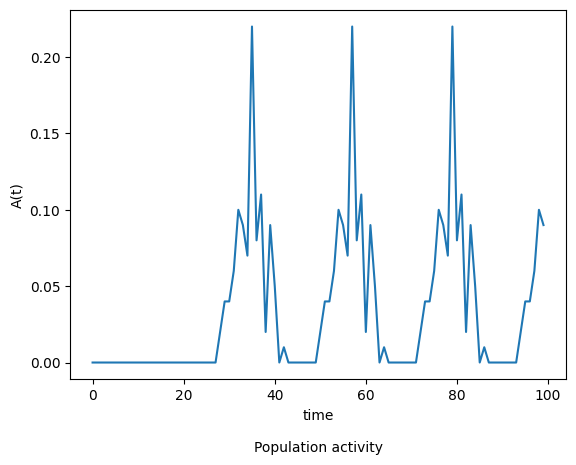

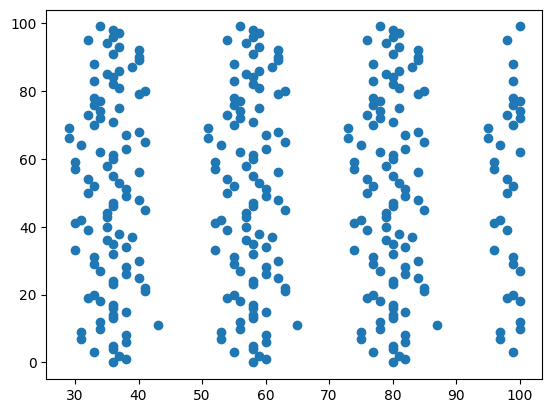

In [39]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    100,
    net=net1,
    behavior={
        2: SetCurrent(value=30),
        3: StepFunction(value=50, t0=20),
        4: InpSyn(),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-60, 40)",
        ),
        9: Recorder(variables=["v", "I", "A"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),

    },
    tag="NG1",
)


SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                3: Fixed_partners(),
                4: SynFun(),
                 
            })

net1.initialize()

net1.simulate_iterations(100)

# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])


plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net1["v", 0][:,:10])
plt.xlabel("time\n\n")
plt.ylabel("u(t)")
plt.show()

plt.plot(net1["I", 0][:,:10])
plt.xlabel("time\n\nInput current")
plt.ylabel("I(t)")
plt.show()

plt.plot(net1["A", 0][:,:1])
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
plt.show()

# Homogeneous network
on LIF

In [40]:
class SynFunExc(Behavior):
	def initialize(self, sg):
		# sg.W = sg.matrix(mode="normal(0.5, 0.3)")
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class SynFunInh(Behavior):
	def initialize(self, sg):
		# sg.W = sg.matrix(mode="normal(0.5, 0.3)")
		sg.W *= -1
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class InpSyn(Behavior):
	def forward(self, ng):
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I


Network['Network_1', 'Network'](Neurons: tensor(100)|2 groups, Synapses: tensor(10000)|4 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](80){2:SetCurrent(value=20,)3:NoiseFun(value=60,)4:InpSyn()5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](20){2:SetCurrent(value=20,)3:NoiseFun(value=60,)4:InpSyn()5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec, ng2_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng2_evrec,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S80xD80){3:Fixed_

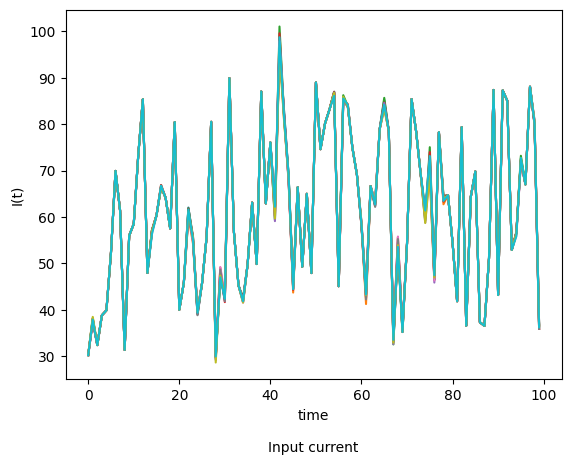

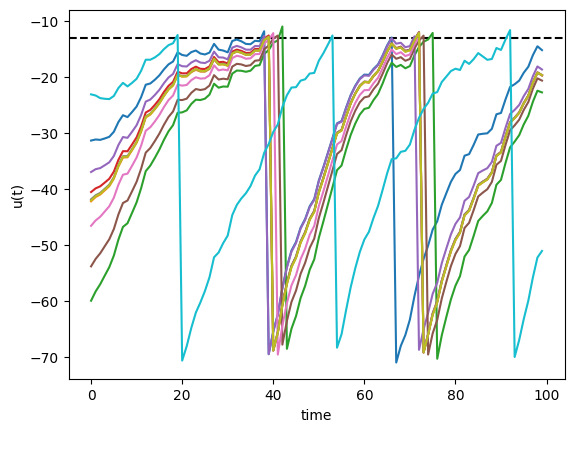

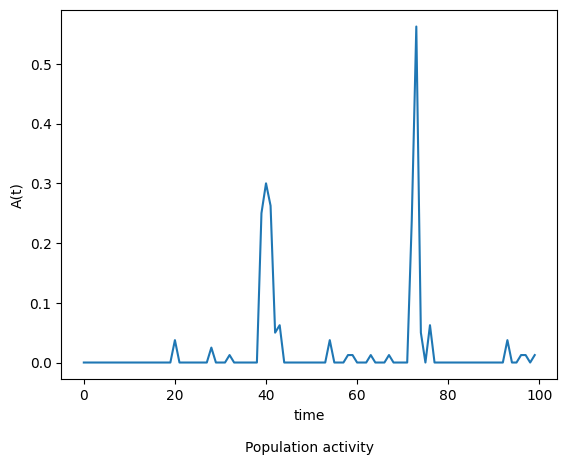

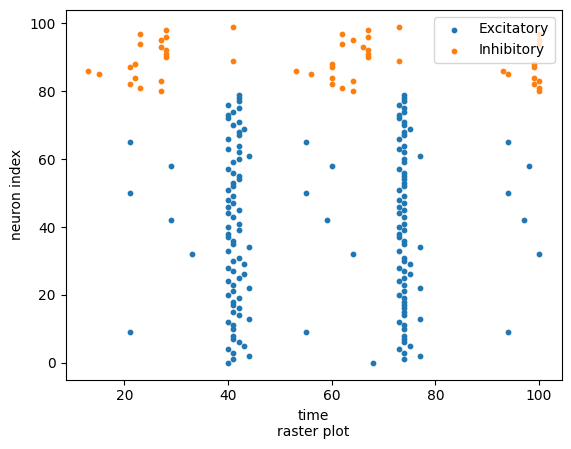

In [41]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    80,
    net=net1,
    behavior={
        2: SetCurrent(value=20),
        3: NoiseFun(value=60),
        4: InpSyn(),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    20,
    net=net1,
    behavior={
        2: SetCurrent(value=20),
        3: NoiseFun(value=60),
        4: InpSyn(),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A"], tag="ng2_rec, ng2_recorder"),
        10: EventRecorder(["spike"], tag="ng2_evrec"),
    },
    tag="NG2",
)

SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                3: Fixed_partners(),
                4: SynFunExc(),
            })
            
SynapseGroup(net=net1, src=ng1, dst=ng2, behavior={
                3: Fixed_partners(),
                4: SynFunExc(),
            })

SynapseGroup(net=net1, src=ng2, dst=ng1, behavior={
                3: Fixed_partners(),
                4: SynFunInh(),
            })

SynapseGroup(net=net1, src=ng2, dst=ng2, behavior={
                3: Fixed_partners(),
                4: SynFunInh(),
            })


net1.initialize()


net1.simulate_iterations(100)



plt.plot(net1["I", 0][:,:10])
plt.xlabel("time\n\nInput current")
plt.ylabel("I(t)")
plt.show()

plt.axhline(-13, color = 'black', linestyle = '--')
plt.plot(net1["v", 0][:,:10])
plt.xlabel("time\n\n")
plt.ylabel("u(t)")
plt.show()

plt.plot(net1["A", 0][:,:1])
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], s=10)
plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1]+80, s=10)
plt.legend(["Excitatory", "Inhibitory"], loc="upper right")
plt.xlabel("time\nraster plot")
plt.ylabel("neuron index")
plt.show()

# Decision making
on LIF

In [42]:
class SynFunExc(Behavior):
	def initialize(self, sg):
		# sg.W = sg.matrix(mode="normal(0.5, 0.3)")
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class SynFunInh(Behavior):
	def initialize(self, sg):
		# sg.W = sg.matrix(mode="normal(0.5, 0.3)")
		sg.W *= -1
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class InpSyn(Behavior):
	def forward(self, ng):
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I


In [43]:
class Fixed_coupling_probability(Behavior):
	def initialize(self, sg):
		self.J_0 = self.parameter("J_0", 500)/1.2
		self.N = sg.dst.size
		self.p = .3
		sg.W = sg.matrix(self.J_0 / (self.N * self.p))
		helper = torch.rand(sg.matrix_dim())
		for i in range(sg.src.size):
			for j in range(self.N):
				if helper[i][j] < self.p:
					helper[i][j] = 1
				else:
					helper[i][j] = 0
		sg.W *= helper


Network['Network_1', 'Network'](Neurons: tensor(200)|3 groups, Synapses: tensor(25600)|6 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](80){2:SetCurrent(value=80,)3:NoiseFun(value=80,)4:InpSyn()5:LIF(tau=15,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A', 'torch.mean(I)'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](80){2:SetCurrent(value=60,)3:NoiseFun(value=150,)4:InpSyn()5:LIF(tau=15,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A', 'torch.mean(I)'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec, ng2_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng2_evrec,arg_0=['spike'],)}
NeuronGroup['NG3', 'NeuronGroup', 'ng'](40){2:SetC

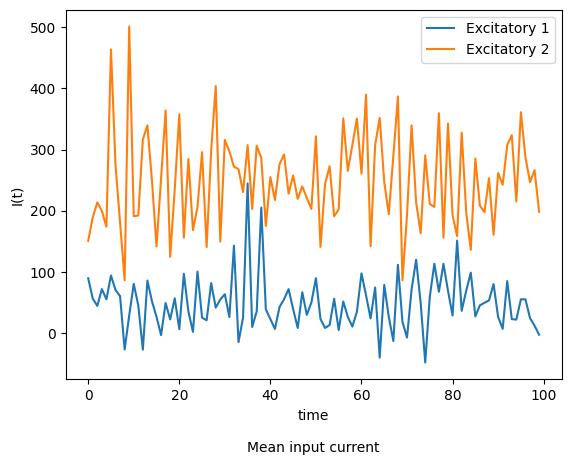

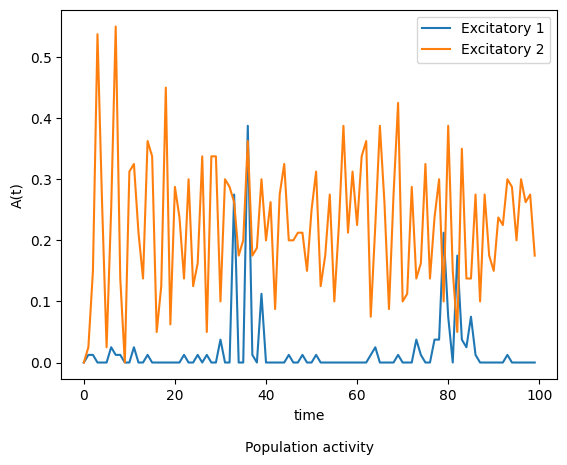

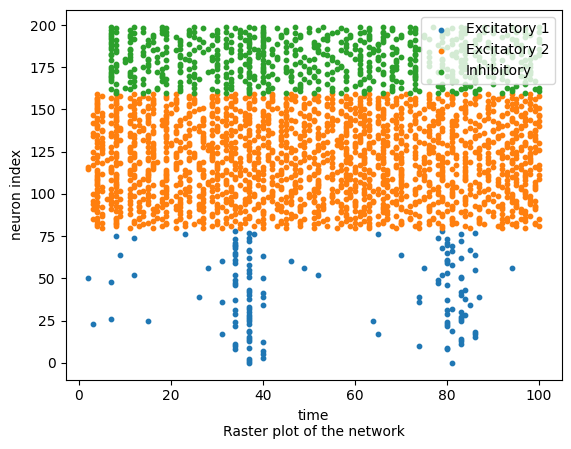

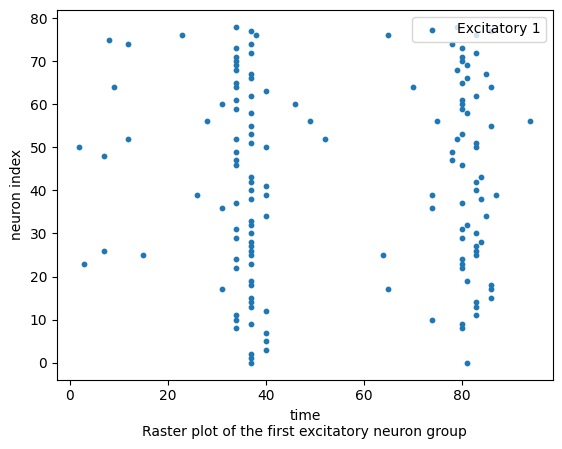

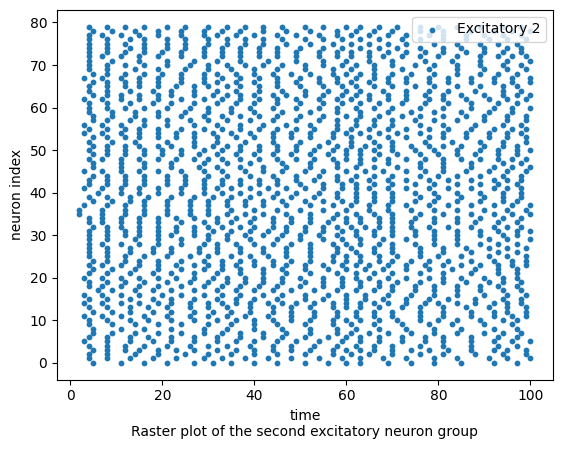

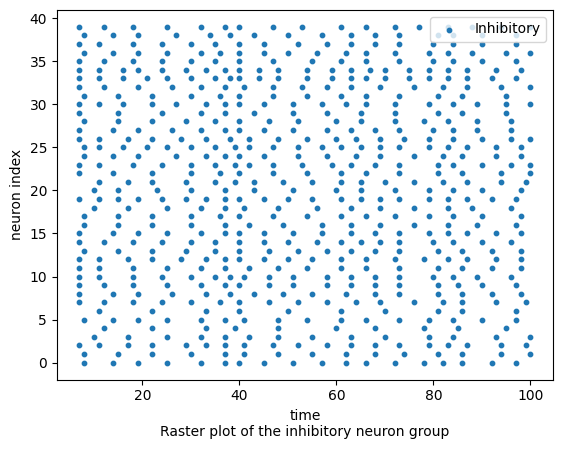

In [44]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    80,
    net=net1,
    behavior={
        2: SetCurrent(value=80),
        3: NoiseFun(value=80),
        4: InpSyn(),
        5: LIF(
            tau=15,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    80,
    net=net1,
    behavior={
        2: SetCurrent(value=60),
        3: NoiseFun(value=150),
        4: InpSyn(),
        5: LIF(
            tau=15,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng2_rec, ng2_recorder"),
        10: EventRecorder(["spike"], tag="ng2_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    40,
    net=net1,
    behavior={
        2: SetCurrent(value=0),
        3: NoiseFun(value=0),
        4: InpSyn(),
        5: LIF(
            tau=12,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng3_rec, ng3_recorder"),
        10: EventRecorder(["spike"], tag="ng3_evrec"),
    },
    tag="NG3",
)

SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                3: Fixed_coupling_probability(J_0=800),
                4: SynFunExc(),
            })
            
# SynapseGroup(net=net1, src=ng1, dst=ng2, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunExc(),
#             })

SynapseGroup(net=net1, src=ng1, dst=ng3, behavior={
                3: Fixed_coupling_probability(J_0=400),
                4: SynFunExc(),
            })

# SynapseGroup(net=net1, src=ng2, dst=ng1, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunExc(),
#             })

SynapseGroup(net=net1, src=ng2, dst=ng2, behavior={
                3: Fixed_coupling_probability(J_0=800),
                4: SynFunExc(),
            })

SynapseGroup(net=net1, src=ng2, dst=ng3, behavior={
                3: Fixed_coupling_probability(J_0=400),
                4: SynFunExc(),
            })

SynapseGroup(net=net1, src=ng3, dst=ng1, behavior={
                3: Fixed_coupling_probability(J_0=600),
                4: SynFunInh(),
            })

SynapseGroup(net=net1, src=ng3, dst=ng2, behavior={
                3: Fixed_coupling_probability(J_0=600),
                4: SynFunInh(),
            })

# SynapseGroup(net=net1, src=ng3, dst=ng3, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunInh(),
#             })


net1.initialize()


net1.simulate_iterations(100)


plt.plot(ng1["torch.mean(I)", 0])
plt.plot(ng2["torch.mean(I)", 0])
plt.legend(["Excitatory 1", "Excitatory 2"], loc="upper right")
plt.xlabel("time\n\nMean input current")
plt.ylabel("I(t)")
plt.show()


plt.plot(ng1["A", 0][:,:1])
plt.plot(ng2["A", 0][:,:1])
plt.legend(["Excitatory 1", "Excitatory 2"], loc="upper right")
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()


plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], s=10)
plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1]+80, s=10)
plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1]+160, s=10)
plt.legend(["Excitatory 1", "Excitatory 2", "Inhibitory"], loc="upper right")
plt.xlabel("time\nRaster plot of the network")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], s=10)
plt.legend(["Excitatory 1"], loc="upper right")
plt.xlabel("time\nRaster plot of the first excitatory neuron group")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1], s=10)
plt.legend(["Excitatory 2"], loc="upper right")
plt.xlabel("time\nRaster plot of the second excitatory neuron group")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1], s=10)
plt.legend(["Inhibitory"], loc="upper right")
plt.xlabel("time\nRaster plot of the inhibitory neuron group")
plt.ylabel("neuron index")
plt.show()

Network['Network_1', 'Network'](Neurons: tensor(200)|3 groups, Synapses: tensor(25600)|6 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](80){2:SetCurrent(value=80,)3:NoiseFun(value=80,)4:InpSyn()5:LIF(tau=15,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A', 'torch.mean(I)'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](80){2:SetCurrent(value=80,)3:NoiseFun(value=150,)4:InpSyn()5:LIF(tau=15,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A', 'torch.mean(I)'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec, ng2_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng2_evrec,arg_0=['spike'],)}
NeuronGroup['NG3', 'NeuronGroup', 'ng'](40){2:SetC

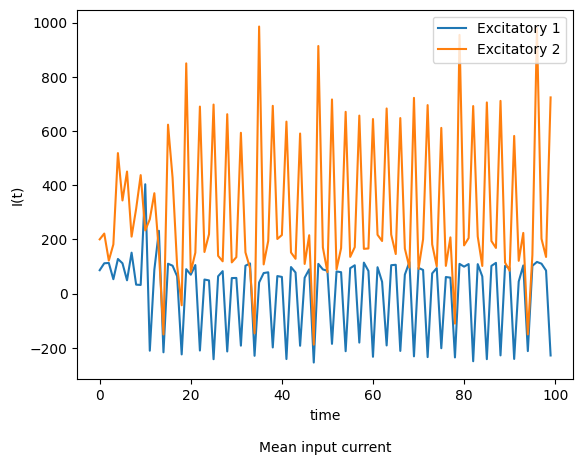

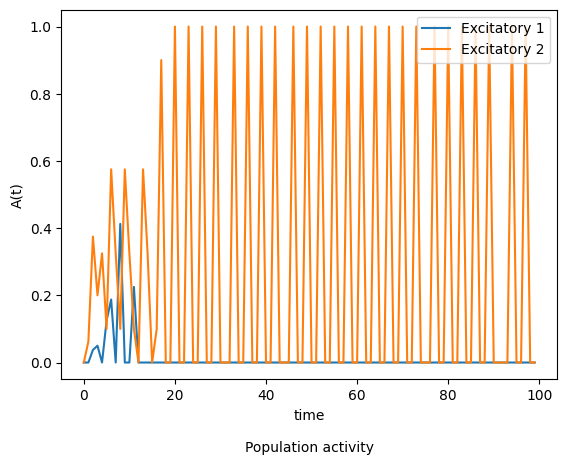

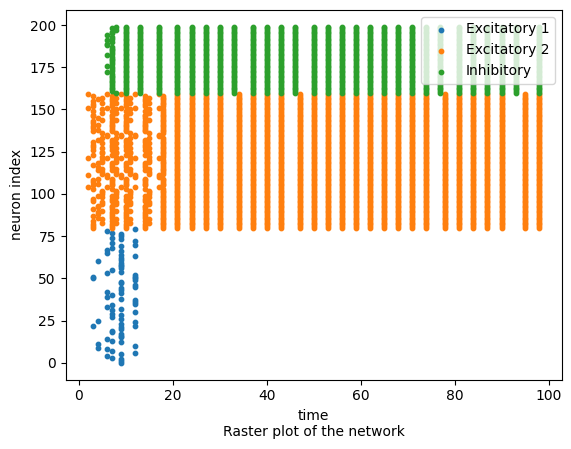

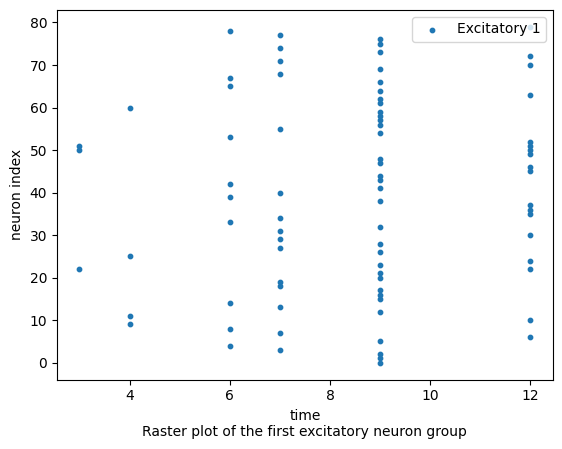

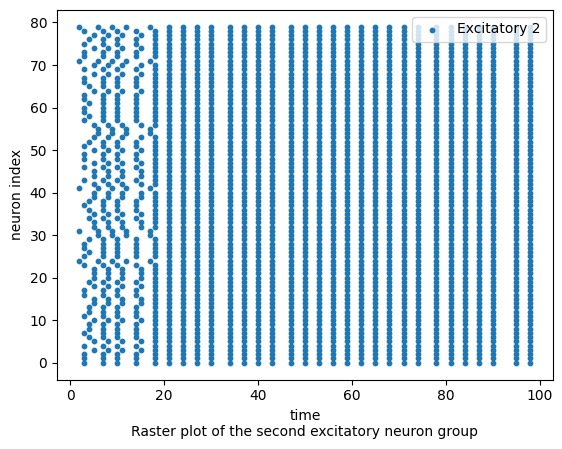

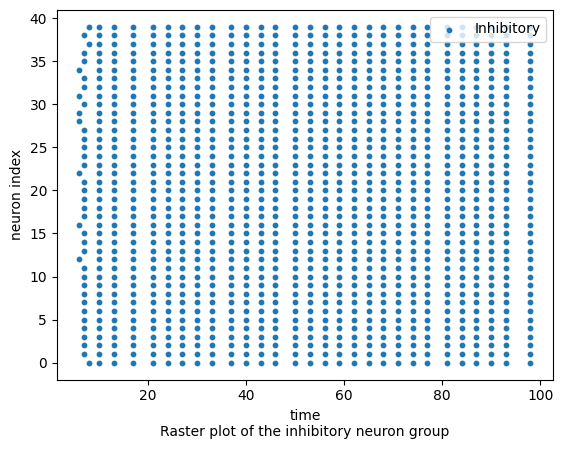

In [45]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    80,
    net=net1,
    behavior={
        2: SetCurrent(value=80),
        3: NoiseFun(value=80),
        4: InpSyn(),
        5: LIF(
            tau=15,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    80,
    net=net1,
    behavior={
        2: SetCurrent(value=80),
        3: NoiseFun(value=150),
        4: InpSyn(),
        5: LIF(
            tau=15,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng2_rec, ng2_recorder"),
        10: EventRecorder(["spike"], tag="ng2_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    40,
    net=net1,
    behavior={
        2: SetCurrent(value=0),
        3: NoiseFun(value=0),
        4: InpSyn(),
        5: LIF(
            tau=12,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng3_rec, ng3_recorder"),
        10: EventRecorder(["spike"], tag="ng3_evrec"),
    },
    tag="NG3",
)

SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                3: Full(J_0=800),
                4: SynFunExc(),
            })
            
# SynapseGroup(net=net1, src=ng1, dst=ng2, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunExc(),
#             })

SynapseGroup(net=net1, src=ng1, dst=ng3, behavior={
                3: Full(J_0=400),
                4: SynFunExc(),
            })

# SynapseGroup(net=net1, src=ng2, dst=ng1, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunExc(),
#             })

SynapseGroup(net=net1, src=ng2, dst=ng2, behavior={
                3: Full(J_0=800),
                4: SynFunExc(),
            })

SynapseGroup(net=net1, src=ng2, dst=ng3, behavior={
                3: Full(J_0=400),
                4: SynFunExc(),
            })

SynapseGroup(net=net1, src=ng3, dst=ng1, behavior={
                3: Full(J_0=600),
                4: SynFunInh(),
            })

SynapseGroup(net=net1, src=ng3, dst=ng2, behavior={
                3: Full(J_0=600),
                4: SynFunInh(),
            })

# SynapseGroup(net=net1, src=ng3, dst=ng3, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunInh(),
#             })


net1.initialize()


net1.simulate_iterations(100)


plt.plot(ng1["torch.mean(I)", 0])
plt.plot(ng2["torch.mean(I)", 0])
plt.legend(["Excitatory 1", "Excitatory 2"], loc="upper right")
plt.xlabel("time\n\nMean input current")
plt.ylabel("I(t)")
plt.show()


plt.plot(ng1["A", 0][:,:1])
plt.plot(ng2["A", 0][:,:1])
plt.legend(["Excitatory 1", "Excitatory 2"], loc="upper right")
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()


plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], s=10)
plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1]+80, s=10)
plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1]+160, s=10)
plt.legend(["Excitatory 1", "Excitatory 2", "Inhibitory"], loc="upper right")
plt.xlabel("time\nRaster plot of the network")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], s=10)
plt.legend(["Excitatory 1"], loc="upper right")
plt.xlabel("time\nRaster plot of the first excitatory neuron group")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1], s=10)
plt.legend(["Excitatory 2"], loc="upper right")
plt.xlabel("time\nRaster plot of the second excitatory neuron group")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1], s=10)
plt.legend(["Inhibitory"], loc="upper right")
plt.xlabel("time\nRaster plot of the inhibitory neuron group")
plt.ylabel("neuron index")
plt.show()

In [46]:
class Fixed_partners(Behavior):
	def initialize(self, sg):
		# sg.W = sg.get_random_synapse_mat_fixed(min_number_of_synapses=10)
		self.J_0=self.parameter("J_0", 500)
		self.C=self.parameter("C",60)
		dim = sg.matrix_dim()
		result = torch.zeros(dim, device=sg.device)
		if self.C != 0:
			for i in range(dim[0]):
				synapses = torch.randperm(dim[1], device=sg.device)[
					:self.C
				]
				result[i, synapses] = torch.ones(len(synapses), device=sg.device)*self.J_0/self.C
		sg.W = result

Network['Network_1', 'Network'](Neurons: tensor(200)|3 groups, Synapses: tensor(25600)|6 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](80){2:SetCurrent(value=80,)3:NoiseFun(value=80,)4:InpSyn()5:LIF(tau=15,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A', 'torch.mean(I)'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](80){2:SetCurrent(value=80,)3:NoiseFun(value=150,)4:InpSyn()5:LIF(tau=15,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'A', 'torch.mean(I)'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec, ng2_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng2_evrec,arg_0=['spike'],)}
NeuronGroup['NG3', 'NeuronGroup', 'ng'](40){2:SetC

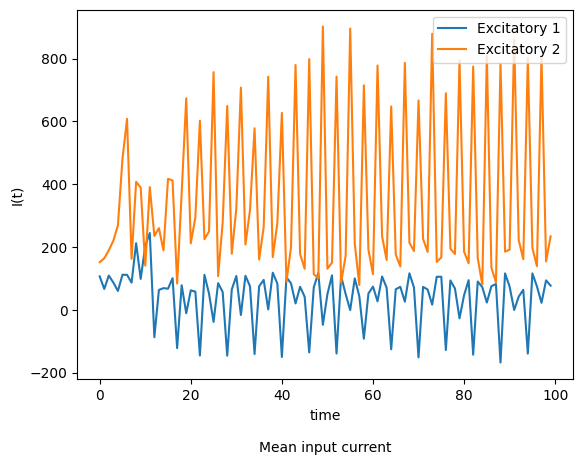

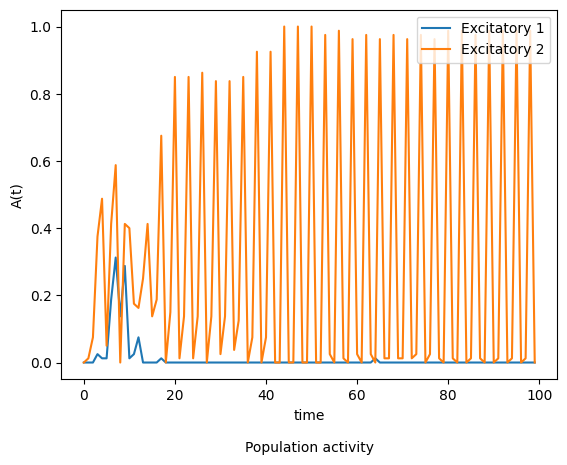

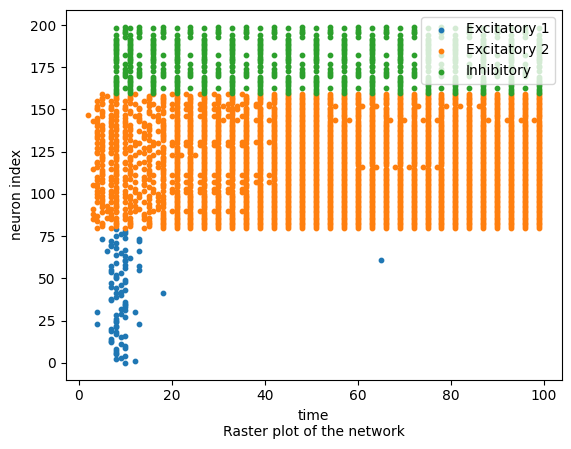

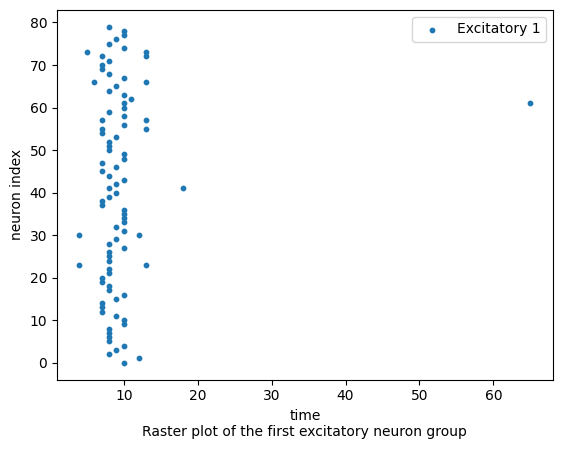

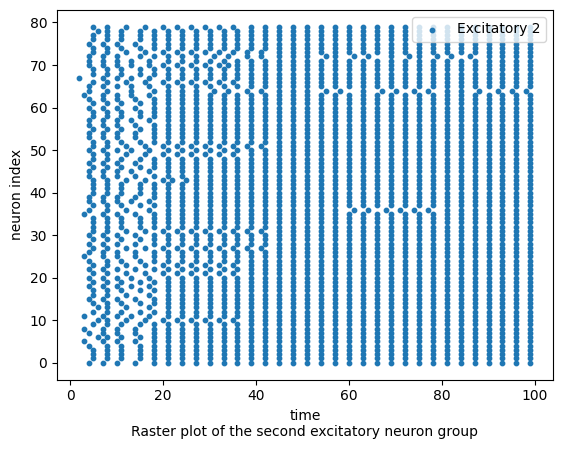

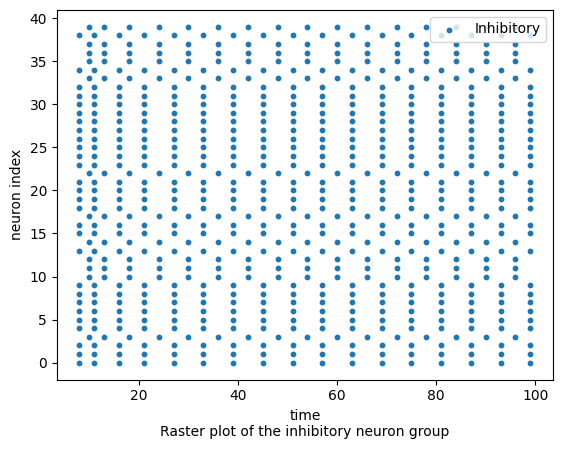

In [47]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    80,
    net=net1,
    behavior={
        2: SetCurrent(value=80),
        3: NoiseFun(value=80),
        4: InpSyn(),
        5: LIF(
            tau=15,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    80,
    net=net1,
    behavior={
        2: SetCurrent(value=80),
        3: NoiseFun(value=150),
        4: InpSyn(),
        5: LIF(
            tau=15,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng2_rec, ng2_recorder"),
        10: EventRecorder(["spike"], tag="ng2_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    40,
    net=net1,
    behavior={
        2: SetCurrent(value=0),
        3: NoiseFun(value=0),
        4: InpSyn(),
        5: LIF(
            tau=12,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "A", "torch.mean(I)"], tag="ng3_rec, ng3_recorder"),
        10: EventRecorder(["spike"], tag="ng3_evrec"),
    },
    tag="NG3",
)

SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
                3: Fixed_partners(J_0=800),
                4: SynFunExc(),
            })
            
# SynapseGroup(net=net1, src=ng1, dst=ng2, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunExc(),
#             })

SynapseGroup(net=net1, src=ng1, dst=ng3, behavior={
                3: Fixed_partners(J_0=400),
                4: SynFunExc(),
            })

# SynapseGroup(net=net1, src=ng2, dst=ng1, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunExc(),
#             })

SynapseGroup(net=net1, src=ng2, dst=ng2, behavior={
                3: Fixed_partners(J_0=800),
                4: SynFunExc(),
            })

SynapseGroup(net=net1, src=ng2, dst=ng3, behavior={
                3: Fixed_partners(J_0=400),
                4: SynFunExc(),
            })

SynapseGroup(net=net1, src=ng3, dst=ng1, behavior={
                3: Fixed_partners(J_0=600),
                4: SynFunInh(),
            })

SynapseGroup(net=net1, src=ng3, dst=ng2, behavior={
                3: Fixed_partners(J_0=600),
                4: SynFunInh(),
            })

# SynapseGroup(net=net1, src=ng3, dst=ng3, behavior={
#                 3: Fixed_coupling_probability(),
#                 4: SynFunInh(),
#             })


net1.initialize()


net1.simulate_iterations(100)


plt.plot(ng1["torch.mean(I)", 0])
plt.plot(ng2["torch.mean(I)", 0])
plt.legend(["Excitatory 1", "Excitatory 2"], loc="upper right")
plt.xlabel("time\n\nMean input current")
plt.ylabel("I(t)")
plt.show()


plt.plot(ng1["A", 0][:,:1])
plt.plot(ng2["A", 0][:,:1])
plt.legend(["Excitatory 1", "Excitatory 2"], loc="upper right")
plt.xlabel("time\n\nPopulation activity")
plt.ylabel("A(t)")
plt.show()


plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], s=10)
plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1]+80, s=10)
plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1]+160, s=10)
plt.legend(["Excitatory 1", "Excitatory 2", "Inhibitory"], loc="upper right")
plt.xlabel("time\nRaster plot of the network")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], s=10)
plt.legend(["Excitatory 1"], loc="upper right")
plt.xlabel("time\nRaster plot of the first excitatory neuron group")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1], s=10)
plt.legend(["Excitatory 2"], loc="upper right")
plt.xlabel("time\nRaster plot of the second excitatory neuron group")
plt.ylabel("neuron index")
plt.show()

plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1], s=10)
plt.legend(["Inhibitory"], loc="upper right")
plt.xlabel("time\nRaster plot of the inhibitory neuron group")
plt.ylabel("neuron index")
plt.show()
